In [1]:
import pandas as pd

In [2]:
url = "https://raw.githubusercontent.com/CDEIUK/bias-mitigation/refs/heads/master/artifacts/data/recruiting/processed/train.csv"

test = pd.read_csv(url)
print(test.head())
print(len(test))

   sex_male  race_white  years_experience  referred      gcse   a_level  \
0         0           1          0.265328         1  0.148817  1.115547   
1         0           1         -1.126253         0  0.148817  1.115547   
2         1           0         -0.082567         1  0.148817 -1.013021   
3         1           1          0.265328         1 -1.065188  0.051263   
4         1           1         -0.778358         1 -1.065188  0.051263   

   russell_group  honours  years_volunteer    income  it_skills  years_gaps  \
0              1        1         2.139888 -0.740776  -0.712629    1.428393   
1              1        1        -0.704762 -0.229262   0.363037   -0.704067   
2              0        0        -0.704762 -1.325363  -1.788296   -0.704067   
3              0        0        -0.704762  1.414890   0.363037    0.362163   
4              0        0         0.717563  0.757230   1.438704   -0.704067   

   quality_cv  employed_yes  
0   -0.919143             1  
1    0.253981 

In [3]:
# White and employed
whiteEmployed_df = test[(test['race_white'] == 0) & (test['employed_yes'] == 1)]

whiteEmployed_df_count = len(whiteEmployed_df)

print(f"White and employed: {whiteEmployed_df_count}")

White and employed: 674


In [4]:
# Colored and employed
whiteEmployed_df = test[(test['race_white'] == 0) & (test['employed_yes'] == 1)]

whiteEmployed_df_count = len(whiteEmployed_df)

print(f"Colored and employed: {whiteEmployed_df_count}")

Colored and employed: 674


In [5]:
# Male ve employed
whiteEmployed_df = test[(test['sex_male'] == 1) & (test['employed_yes'] == 1)]

whiteEmployed_df_count = len(whiteEmployed_df)

print(f"Male and employed: {whiteEmployed_df_count}")

Male and employed: 1401


In [6]:
# Female ve employed
whiteEmployed_df = test[(test['sex_male'] == 0) & (test['employed_yes'] == 1)]

whiteEmployed_df_count = len(whiteEmployed_df)

print(f"Female and employed: {whiteEmployed_df_count}")

Female and employed: 884


race ve genderların eşit olması lazım
datasette eşit AMA
white olduğunun imply eden ve black olduğunu imply eden özelliklerin de hiring kararında eşit olması lazım
bunu yapıp yapmadaıüını analiz etmemiz lazım

VE demograohic parity

In [7]:
employed_by_sex = test[["sex_male", "employed_yes"]].groupby("sex_male").mean()
print(employed_by_sex)


          employed_yes
sex_male              
0             0.295159
1             0.466223


Karar aşamasında female karakteristik insanları reject etme olasılığı daha yüksek

In [8]:
employed_by_race = test[["race_white", "employed_yes"]].groupby("race_white").mean()
print(employed_by_race)


            employed_yes
race_white              
0               0.230743
1               0.523222


Acceptad'larda eşit olsa bile rejectadlarda beyaz olmayanlar daha çok reject edilebilir -> beyaz karakteristikleri olmayanların kabul edilme olasılığı daha düşük olabilir

In [9]:
cv_by_race = test[["race_white", "quality_cv"]].groupby("race_white").mean()
print(cv_by_race)


            quality_cv
race_white            
0             0.006184
1            -0.005866


racial disparity yok -> racist bastards

In [10]:
cv_by_sex = test[["sex_male", "quality_cv"]].groupby("sex_male").mean()
print(cv_by_sex)


          quality_cv
sex_male            
0           0.009956
1          -0.009923


sexual disparity yok

In [11]:
from pathlib import Path
import joblib


from fairlearn.metrics import (
    demographic_parity_difference,
    demographic_parity_ratio,
    equalized_odds_difference,
    equalized_odds_ratio,
)

In [12]:
test_url = "https://raw.githubusercontent.com/CDEIUK/bias-mitigation/refs/heads/master/artifacts/data/recruiting/processed/test.csv"
test = pd.read_csv(test_url)
test_raw_url = "https://raw.githubusercontent.com/CDEIUK/bias-mitigation/refs/heads/master/artifacts/data/recruiting/raw/test.csv"
test_raw = pd.read_csv(test_raw_url)

model = joblib.load("baseline.pkl")

c:\Users\suuser\AppData\Local\anaconda3\envs\DSA201\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LabelBinarizer from version 0.23.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\suuser\AppData\Local\anaconda3\envs\DSA201\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MLPClassifier from version 0.23.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [13]:
test_prob = model.predict_proba(test.drop(columns="employed_yes"))[:, 1]
test_pred = test_prob > 0.5
test_accuracy = model.score(
    test.drop(columns="employed_yes"), test.employed_yes
)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

Test accuracy: 86.15%


c:\Users\suuser\AppData\Local\anaconda3\envs\DSA201\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
c:\Users\suuser\AppData\Local\anaconda3\envs\DSA201\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


In [14]:
dpd = demographic_parity_difference(
    test.employed_yes, test_pred, sensitive_features=test.sex_male,
)
dpr = demographic_parity_ratio(
    test.employed_yes, test_pred, sensitive_features=test.sex_male,
)

print(f"Demographic parity difference: {dpd:.3f}")
print(f"Demographic parity ratio: {dpr:.3f}")

Demographic parity difference: 0.173
Demographic parity ratio: 0.590


In [15]:
dpd = demographic_parity_difference(
    test.employed_yes, test_pred, sensitive_features=test.race_white,
)
dpr = demographic_parity_ratio(
    test.employed_yes, test_pred, sensitive_features=test.race_white,
)

print(f"Demographic parity difference: {dpd:.3f}")
print(f"Demographic parity ratio: {dpr:.3f}")

Demographic parity difference: 0.327
Demographic parity ratio: 0.345


Race'de ration yüksek. Yani racistler. 1'e yaklaştırmak istiyoruz. (Include DEI programs hehe)

In [16]:
eod = equalized_odds_difference(
    test.employed_yes, test_pred, sensitive_features=test.sex_male,
)
eor = equalized_odds_ratio(
    test.employed_yes, test_pred, sensitive_features=test.sex_male,
)

print(f"Equalised odds difference: {eod:.3f}")
print(f"Equalised odds ratio: {eor:.3f}")

Equalised odds difference: 0.088
Equalised odds ratio: 0.650


Difference küçücük.

In [17]:
eod = equalized_odds_difference(
    test.employed_yes, test_pred, sensitive_features=test.race_white,
)
eor = equalized_odds_ratio(
    test.employed_yes, test_pred, sensitive_features=test.race_white,
)

print(f"Equalised odds difference: {eod:.3f}")
print(f"Equalised odds ratio: {eor:.3f}")

Equalised odds difference: 0.133
Equalised odds ratio: 0.246


Bunda difference daha yüksek. Rac,st rather than sexist.

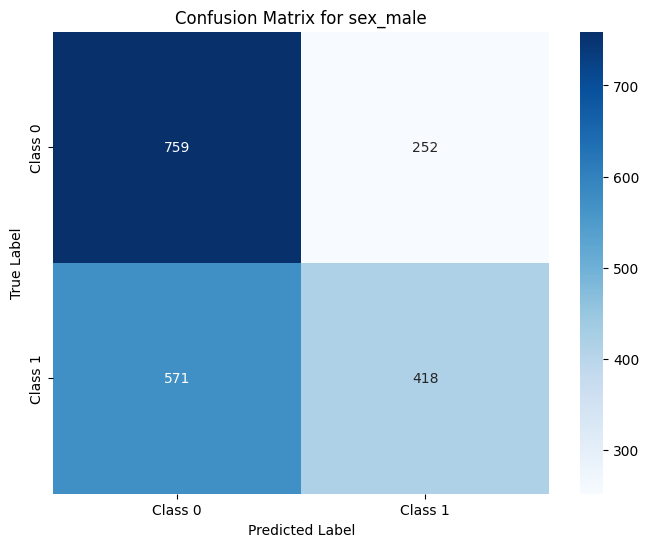

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd

# Assuming 'test' DataFrame and 'test_pred' predictions are already defined

# Replace 'your_column_name' with the actual column name you want to use
column_of_interest = "sex_male"

# Ensure the column exists in your DataFrame
if column_of_interest in test.columns:
    # Create the confusion matrix
    cm = confusion_matrix(test[column_of_interest], test_pred)

    # Define labels for the plot (replace with your actual label names)
    labels = ['Class 0', 'Class 1'] # Replace with meaningful labels for your column

    # Create a heatmap for the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {column_of_interest}')
    plt.show()


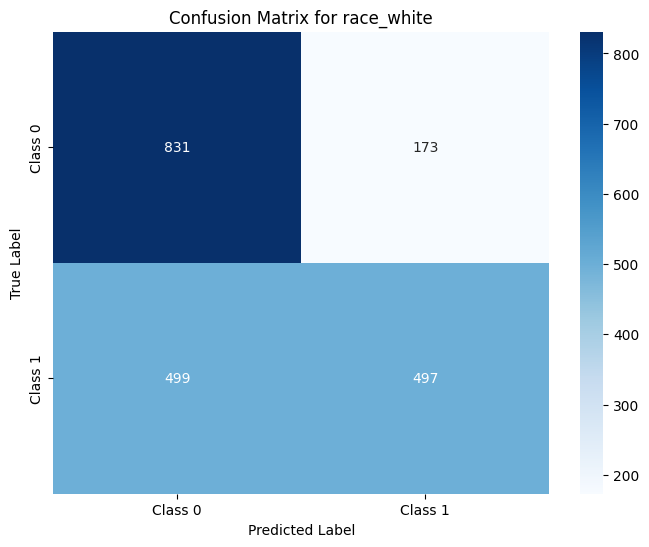

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd


column_of_interest = "race_white"

# Ensure the column exists in your DataFrame
if column_of_interest in test.columns:
    # Create the confusion matrix
    cm = confusion_matrix(test[column_of_interest], test_pred)

    # Define labels for the plot (replace with your actual label names)
    labels = ['Class 0', 'Class 1'] # Replace with meaningful labels for your column

    # Create a heatmap for the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {column_of_interest}')
    plt.show()


is racist

Modelin accuracy .8in üstünde olsa da protected karakteristikler var hire edilen insanlarda. Bunlardan sex herhangib ir ciddi male-female farklılığı göstermiyor. Bu yüzden bunun zerine train edilecek harhangi bir model sexism açısında ciddi bir sorun yaratmayacaktır diye tahmin ediyoruz.

On the other hand, beyazlar ve diğer ırklar arasında demografik farklılık var. Özellikle hire edilip edilmeme konusunda. Modeli race göz önünde bulundurmadan train edilse bile bu insanların karakteristikleri diğer featurlar arasnda encoded olabilir ve bu sebeple racism fark edilmeden yapılablir.

2 protected karakteristikten de bahsettik. Done. Gelince bunlara çözüm bulmamız lazım. Başka bir model train yarınlü ekip edecek :)

Hedef: DP Difference = 0 ve DP Ratio = 1

kısaca model beyazlara göre beyaz olmayanları daha az işe alıyor.

eps=0.01 demek “DP farkı en fazla %1 olsun” diyoruz.

Eps’i biraz artırıp/azaltarak accuracy-fairness arasındaki dengeyi görebilirsin.

Eğittiğin herhangi bir modeli (ör. RandomForest) aldıktan sonra, çıktılarına ThresholdOptimizer uygulayarak da DP’ı sıfıra yaklaştırabilirsin.

In [20]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from aif360.datasets import BinaryLabelDataset
from aif360.algorithms.preprocessing import Reweighing
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
from fairlearn.postprocessing import ThresholdOptimizer

# 3) Helper metric functions
def demographic_parity(sens, y_pred):
    sr_p   = np.mean(y_pred[sens==1])
    sr_up  = np.mean(y_pred[sens==0])
    return sr_p - sr_up, (sr_up/sr_p if sr_p else np.nan)

def equalized_odds(sens, y_true, y_pred):
    def rates(mask):
        tn, fp, fn, tp = confusion_matrix(y_true[mask], y_pred[mask]).ravel()
        return tp/(tp+fn), fp/(fp+tn)
    p_mask   = sens==1
    up_mask  = sens==0
    tpr_p, fpr_p = rates(p_mask)
    tpr_u, fpr_u = rates(up_mask)
    return tpr_p - tpr_u, fpr_p - fpr_u

def evaluate(name, y_pred, y_true, sens_dict):
    print(f"\n=== {name} ===")
    print(f"Accuracy: {accuracy_score(y_true, y_pred)*100:.2f}%")
    for attr, sens in sens_dict.items():
        dp_diff, dp_ratio     = demographic_parity(sens, y_pred)
        eo_tpr_diff, eo_fpr_diff = equalized_odds(sens, y_true, y_pred)
        print(f"{attr:12s} | DP Diff: {dp_diff:6.3f}  DP Ratio: {dp_ratio:6.3f}  "
              f"EO TPR Diff: {eo_tpr_diff:6.3f}  EO FPR Diff: {eo_fpr_diff:6.3f}")

# 4) Load datasets
train_url = "https://raw.githubusercontent.com/CDEIUK/bias-mitigation/refs/heads/master/artifacts/data/recruiting/processed/train.csv"
test_url  = "https://raw.githubusercontent.com/CDEIUK/bias-mitigation/refs/heads/master/artifacts/data/recruiting/processed/test.csv"
df_train  = pd.read_csv(train_url)
df_test   = pd.read_csv(test_url)

y_train = df_train['employed_yes'].values
y_test  = df_test['employed_yes'].values

X_train = df_train.drop(columns=['employed_yes'])
X_test  = df_test.drop(columns=['employed_yes'])

sensitive = {
    "race_white": df_test['race_white'].values,
    "sex_male":   df_test['sex_male'].values
}

# 5) Baseline
clf_base = RandomForestClassifier(random_state=42).fit(X_train, y_train)
y_base   = clf_base.predict(X_test)
evaluate("Baseline RF", y_base, y_test, sensitive)

# 6) Reweighing for each sensitive attribute
for attr in sensitive:
    # prepare AIF360 dataset
    df_aif = df_train.copy()
    df_aif['label'] = df_aif['employed_yes']
    df_aif[attr]    = df_aif[attr].astype(int)
    bld = BinaryLabelDataset(
        df=df_aif, 
        label_names=['label'], 
        protected_attribute_names=[attr]
    )
    rw = Reweighing(
        privileged_groups=[{attr:1}],
        unprivileged_groups=[{attr:0}]
    )
    btr = rw.fit_transform(bld)
    cols = btr.feature_names
    Xrw = pd.DataFrame(btr.features, columns=cols).drop(columns=['employed_yes'], errors='ignore').values
    yrw = btr.labels.ravel()
    wgt = btr.instance_weights
    # train & predict
    clf = RandomForestClassifier(random_state=42)
    clf.fit(Xrw, yrw, sample_weight=wgt)
    # align test
    Xtest_rw = df_test[cols].drop(columns=['employed_yes'], errors='ignore').values
    y_rw = clf.predict(Xtest_rw)
    evaluate(f"Reweighing ({attr})", y_rw, y_test, sensitive)

# 7) Unawareness (drop both attrs simultaneously)
drop_cols = ['employed_yes','race_white','sex_male']
Xua_train = df_train.drop(columns=drop_cols)
Xua_test  = df_test.drop(columns=drop_cols)
clf_ua    = RandomForestClassifier(random_state=42).fit(Xua_train, y_train)
y_ua      = clf_ua.predict(Xua_test)
evaluate("Unawareness", y_ua, y_test, sensitive)

# 8) In-processing (EG) for each attr
for attr in sensitive:
    Xeg_train = df_train.drop(columns=['employed_yes',attr])
    Xeg_test  = df_test.drop(columns=['employed_yes',attr])
    sg_train  = df_train[attr].values
    eg = ExponentiatedGradient(
        estimator=LogisticRegression(solver='liblinear'),
        constraints=DemographicParity(),
        eps=0.01
    )
    eg.fit(Xeg_train, y_train, sensitive_features=sg_train)
    y_eg = eg.predict(Xeg_test)
    evaluate(f"EG (eps=0.01) ({attr})", y_eg, y_test, sensitive)

# 9) Post-processing (ThresholdOptimizer) for each attr
for attr in sensitive:
    topt = ThresholdOptimizer(
        estimator=clf_base,
        constraints="demographic_parity",
        prefit=True
    )
    topt.fit(X_test, y_test, sensitive_features=df_test[attr].values)
    y_to = topt.predict(X_test, sensitive_features=df_test[attr].values)
    evaluate(f"Post-proc ({attr})", y_to, y_test, sensitive)


pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[inFairness]'



=== Baseline RF ===
Accuracy: 84.65%
race_white   | DP Diff:  0.333  DP Ratio:  0.355  EO TPR Diff:  0.144  EO FPR Diff:  0.131
sex_male     | DP Diff:  0.162  DP Ratio:  0.625  EO TPR Diff:  0.080  EO FPR Diff:  0.027

=== Reweighing (race_white) ===
Accuracy: 84.25%
race_white   | DP Diff:  0.313  DP Ratio:  0.382  EO TPR Diff:  0.124  EO FPR Diff:  0.112
sex_male     | DP Diff:  0.152  DP Ratio:  0.644  EO TPR Diff:  0.066  EO FPR Diff:  0.021

=== Reweighing (sex_male) ===
Accuracy: 83.65%
race_white   | DP Diff:  0.339  DP Ratio:  0.346  EO TPR Diff:  0.163  EO FPR Diff:  0.144
sex_male     | DP Diff:  0.140  DP Ratio:  0.666  EO TPR Diff:  0.050  EO FPR Diff:  0.014

=== Unawareness ===
Accuracy: 83.10%
race_white   | DP Diff:  0.258  DP Ratio:  0.472  EO TPR Diff:  0.068  EO FPR Diff:  0.058
sex_male     | DP Diff:  0.125  DP Ratio:  0.704  EO TPR Diff:  0.005  EO FPR Diff:  0.018

=== EG (eps=0.01) (race_white) ===
Accuracy: 77.40%
race_white   | DP Diff:  0.022  DP Ratio:  0.

# Contestability

In [23]:
import os
import uuid
import datetime
import json

# ——— 1) Paths & Init ———
AUDIT_LOG   = "audit_log.csv"
APPEALS_LOG = "appeals_log.csv"

def init_logs():
    # Create audit log CSV if missing
    if not os.path.exists(AUDIT_LOG):
        pd.DataFrame(columns=['timestamp','applicant_id','features','prediction']) \
          .to_csv(AUDIT_LOG, index=False)
    # Create appeals log CSV if missing
    if not os.path.exists(APPEALS_LOG):
        pd.DataFrame(columns=[
            'appeal_id','timestamp','applicant_id',
            'reason','status','reviewer_notes','review_timestamp'
        ]).to_csv(APPEALS_LOG, index=False)

init_logs()


# ——— 2) Contestability Functions ———
def log_decision(applicant_id: str, features: dict, prediction: int):
    """Append decision to audit log."""
    record = {
        "timestamp": datetime.datetime.utcnow().isoformat(),
        "applicant_id": applicant_id,
        "features": json.dumps(features),
        "prediction": int(prediction)
    }
    pd.DataFrame([record]) \
      .to_csv(AUDIT_LOG, mode="a", header=False, index=False)

def submit_appeal(applicant_id: str, reason: str):
    """User calls to contest a rejected decision."""
    appeal = {
        "appeal_id": str(uuid.uuid4()),
        "timestamp": datetime.datetime.utcnow().isoformat(),
        "applicant_id": applicant_id,
        "reason": reason,
        "status": "OPEN",
        "reviewer_notes": "",
        "review_timestamp": ""
    }
    pd.DataFrame([appeal]) \
      .to_csv(APPEALS_LOG, mode="a", header=False, index=False)
    return appeal["appeal_id"]

def list_open_appeals():
    """Return DataFrame of OPEN appeals, safe if file/column missing."""
    if not os.path.exists(APPEALS_LOG):
        return pd.DataFrame(columns=['appeal_id','timestamp','applicant_id','reason','status','reviewer_notes','review_timestamp'])
    df = pd.read_csv(APPEALS_LOG)
    if "status" not in df.columns:
        return df
    return df[df["status"] == "OPEN"]

def resolve_appeal(appeal_id: str, approved: bool, notes: str):
    """Approve or reject an appeal and write back to CSV."""
    df = pd.read_csv(APPEALS_LOG)
    idx = df.index[df["appeal_id"] == appeal_id]
    if idx.empty:
        raise KeyError(f"No such appeal {appeal_id}")
    i = idx[0]
    df.at[i, "status"]          = "APPROVED" if approved else "REJECTED"
    df.at[i, "reviewer_notes"]   = notes
    df.at[i, "review_timestamp"] = datetime.datetime.utcnow().isoformat()
    df.to_csv(APPEALS_LOG, index=False)
    return df.loc[i].to_dict()
